<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/deeplabcut_data_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a model with DeepLabCut data

This an example notebook for using DeepLabCut (http://www.deeplabcut.org) formatted data within DeepPoseKit. This notebook shows you how to use the [openfield example dataset](https://github.com/AlexEMG/DeepLabCut/tree/master/examples/openfield-Pranav-2018-10-30) from Mathis et al. (2018). to train a deep learning model using data augmentation and callbacks for logging the training process and saving the best model during training.

**NOTE**: This example currently only supports basic functionality from DeepLabCut (no cropping, etc.). It assumes each image contains a single individual (or multiple individuals are labeled as separate keypoints) and assumes all images are the same size/resolution. If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)


Install DeepPoseKit and download the DeepLabCut repository

In [1]:
import sys
!{sys.executable} -m pip install git+https://github.com/jgraving/deepposekit 

  Cloning https://github.com/jgraving/deepposekit to /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-eamlb8_9
  Running command git clone -q https://github.com/jgraving/deepposekit /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-req-build-eamlb8_9
  Stored in directory: /private/var/folders/st/hhx75tj167g4qfsmb3rt8r7r0000gn/T/pip-ephem-wheel-cache-d4_gnhlz/wheels/af/2f/a1/97dbc668c1928ad2c177b380a22ec38f854b19fac8399b0846
Successfully built deepposekit
  Found existing installation: deepposekit 0.3.0.dev0
    Uninstalling deepposekit-0.3.0.dev0:
      Successfully uninstalled deepposekit-0.3.0.dev0


In [1]:
!git clone https://github.com/alexemg/deeplabcut


fatal: destination path 'deeplabcut' already exists and is not an empty directory.


In [2]:
import tensorflow as tf

#tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DLCDataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint

import time
from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

# Create a data generator
This creates a `DLCDataGenerator` for loading annotated data from DeepLabCut. Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

**NOTE**: This example currently only supports basic functionality from DeepLabCut (no cropping, etc.). It assumes each image contains a single individual (or multiple individuals are labeled as separate keypoints) and assumes all images are the same size/resolution. If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

You can also look at the doc string for more explanation:

In [3]:
DLCDataGenerator?

In [ ]:
data_generator = DLCDataGenerator(
    projectpath='./deeplabcut/examples/openfield-Pranav-2018-10-30/'
)

data_generator.config

In [41]:
# manually add a posture graph for drawing lines between keypoints
data_generator.graph = np.array([-1, 0, 0, 0]) # snout (index 0) is parent node to all other nodes
# manually add a swap index for swapping left and right keypoints during augmentation
data_generator.swap_index = np.array([-1, 2, 1, -1]) # this swaps the left ear (index 1) and the right ear (index 2)


Visualize the outputs

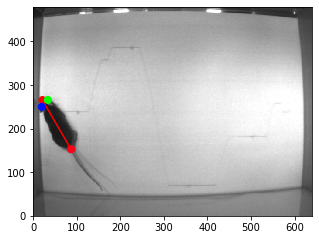

In [42]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )

plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)
plt.xlim(0, data_generator.image_shape[1])
plt.ylim(0, data_generator.image_shape[0])

plt.show()

# Create an augmentation pipeline
DeepPoseKit works with augmenters from the [imgaug package](https://github.com/aleju/imgaug).
This is a short example using spatial augmentations with axis flipping and affine transforms
See https://github.com/aleju/imgaug for more documentation on augmenters.


In [143]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                            translate_percent={'x': (-0.5, 0.5), 'y': (-0.5, 0.5)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.5, 1.5),
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.5, sometimes))
augmenter.append(iaa.Sometimes(0.5, iaa.Affine(rotate=(-180, 180),
                            order=ia.ALL,
                            cval=ia.ALL))
                 )
augmenter = iaa.Sequential(augmenter)


Load an image-keypoints pair, apply augmentation, visualize it.

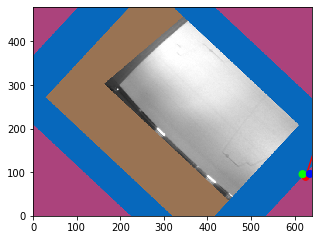

In [147]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )

plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)
plt.xlim(0, data_generator.image_shape[1])
plt.ylim(0, data_generator.image_shape[0])

plt.show()

# Create a TrainingGenerator
This creates a `TrainingGenerator` from the `DLCDataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DLCDataGenerator` to load image-keypoints pairs and then applies the augmenter and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs. Visualizing the outputs also works best with `downsample_factor=0`. You can also look at the doc string for more explanation:


In [148]:
TrainingGenerator?

In [149]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.1,
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 105,
 'n_validation': 11,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (120, 160),
 'n_output_channels': 10,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'projectpath': './deeplabcut/examples/openfield-Pranav-2018-10-30/',
 'generator': 'DLCDataGenerator',
 'n_samples': 116,
 'image_shape': (480, 640, 3),
 'keypoints_shape': (4, 2)}

# Check the training generator output
This plots the training data output from the `TrainingGenerator` to ensure that the augmentation is working, rerun this cell to see random augmentations. 

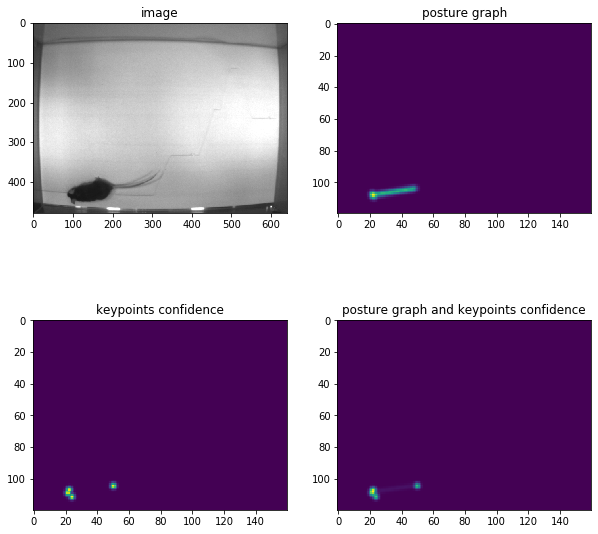

In [150]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. Look at the doc strings for more information:

In [151]:
from deepposekit.models import DeepLabCut, StackedDenseNet, LEAP

In [161]:
#model = StackedDenseNet(train_generator, n_stacks=1, growth_rate=32, n_transitions=-1)
#model = DeepLabCut(train_generator, backbone="resnet50")
model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35)
#model = DeepLabCut(train_generator, backbone="densenet121")
#model = LEAP(train_generator)
model.get_config()

{'name': 'DeepLabCut',
 'subpixel': True,
 'weights': 'imagenet',
 'backbone': 'densenet121',
 'alpha': None,
 'n_train': 105,
 'n_validation': 11,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (120, 160),
 'n_output_channels': 10,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': True,
 'projectpath': './deeplabcut/examples/openfield-Pranav-2018-10-30/',
 'generator': 'DLCDataGenerator',
 'n_samples': 116,
 'image_shape': (480, 640, 3),
 'keypoints_shape': (4, 2)}

In [162]:
model.train_model.summary()

Model: "DeepLabCut"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
float_2 (Float)              (None, 480, 640, 3)       0         
_________________________________________________________________
image_net_preprocess_2 (Imag (None, 480, 640, 3)       0         
_________________________________________________________________
densenet121 (Model)          (None, 30, 40, 1024)      7037504   
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 60, 80, 20)        184340    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 120, 160, 10)      1810      
Total params: 7,223,654
Trainable params: 7,140,006
Non-trainable params: 83,648
_________________________________________

# Test the prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [163]:
data_size = (
    100,
    train_generator.height,
    train_generator.width,
    train_generator.n_channels,
)
x = np.random.randint(0, 255, data_size, dtype="uint8")
t0 = time.time()
y = model.predict(x, batch_size=10, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

100/100 [==============================] - 59s 589ms/sample
1.6959925549301433


# Define callbacks to enhance model training
Here you can define callbacks to pass to the model for use during training


`Logger` evaluates the validation set at the end of each epoch and saves the evaluation data to a HDF5 log file:

In [164]:
logger = Logger(validation_batch_size=10
    #HOME + "deeplabcut_log_dlcmobilenet.h5", validation_batch_size=10
)

`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training:

In [165]:
reduce_lr = ReduceLROnPlateau("val_loss", factor=0.2, verbose=1, patience=20)

`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually:

In [166]:
model_checkpoint = ModelCheckpoint(
    "deeplabcut_best_model_dlcmobilenet.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    optimizer=True,
)

`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment:

In [167]:
early_stop = EarlyStopping("val_loss", min_delta=0.001, patience=100, verbose=1)

Create a list of callbacks to pass to the model

In [168]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

# Fit the model

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset. See the doc string for details:

In [169]:
model.fit(
    batch_size=5,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=1000,
    n_workers=8,
    steps_per_epoch=100,
)

Epoch 1/1000
 81/100 [=======================>......] - ETA: 5:34 - loss: 8.5181

KeyboardInterrupt: 

# Load the model and resume training

This loads the saved model and passes it the augmentation pipeline and `DataGenerator` from earlier.

In [17]:
from deepposekit.models import load_model

#data_generator = DLCDataGenerator(
#    projectpath='./deeplabcut/examples/openfield-Pranav-2018-10-30/'
#)

model = load_model(
    "deeplabcut_best_model_dlcmobilenet.h5",
    augmenter=augmenter,
    generator=data_generator,
)

W0927 10:53:47.558109 4679321024 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0927 10:53:47.559090 4679321024 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0927 10:53:47.560901 4679321024 deprecation.py:506] From /Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.

To resume training, simply call `model.fit` again.

In [21]:
model.fit(
    batch_size=5,
    validation_batch_size=10,
    callbacks=callbacks,
    epochs=1000,
    n_workers=8,
    steps_per_epoch=100,
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 5s - loss: 222.8757 - output_0_loss: 120.1098 - output_1_loss: 102.7660
Epoch 00001: val_loss improved from 211.91043 to 210.45260, saving model to /Users/jake/deepposekit-data/datasets/fly/best_model_densenet.h5


KeyboardInterrupt: 